<a href="https://colab.research.google.com/github/GabrielaGroenenewegenVanDerWeijden/DS_Ass2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [5]:
!pip install tensorflow

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import os

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [8]:
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize

                data.append((resized_arr, class_num))
            except Exception as e:
                print(f"Error processing {img}: {e}")


    return np.array(data, dtype=object)

### Loading the data set

In [10]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val/')

### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

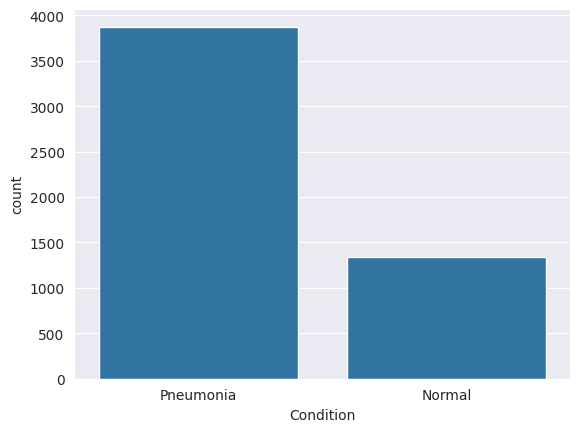

In [11]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

Text(0.5, 1.0, 'NORMAL')

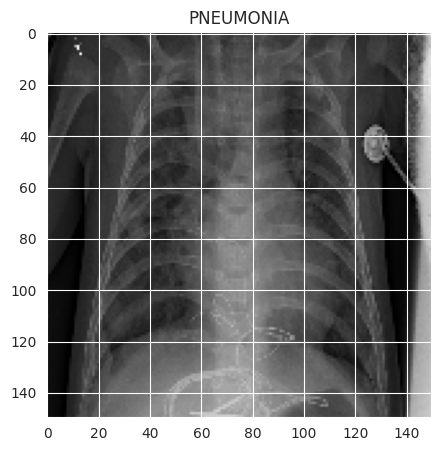

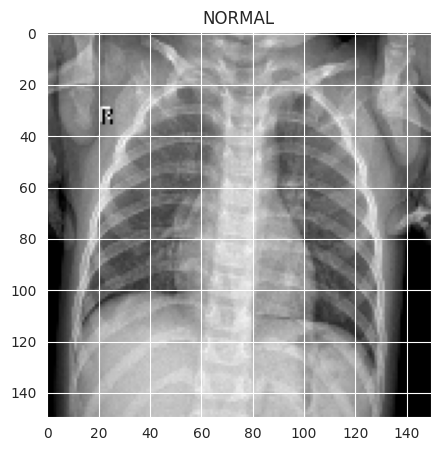

In [12]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])


plt.figure(figsize= (5,5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)


x_test = x_test.reshape(-1, img_size, img_size, 1)


x_val = x_val.reshape(-1, img_size, img_size, 1)


### Data Augmentation

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [16]:
datagen.fit(x_train)

### Training the Model

In [17]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [19]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 29s 165ms/step - loss: 0.6442 - accuracy: 0.8472 - val_loss: 6.6829 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 27s 163ms/step - loss: 0.2510 - accuracy: 0.9028 - val_loss: 21.1006 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9222
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 27s 163ms/step - loss: 0.2190 - accuracy: 0.9222 - val_loss: 17.4395 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 27s 164ms/step - loss: 0.1536 - accuracy: 0.9467 - val_loss: 19.2931 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9549
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===================

In [20]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 36ms/step - loss: 0.2555 - accuracy: 0.9215
Loss of the model is -  0.25545358657836914
20/20 [==============================] - 1s 36ms/step - loss: 0.2555 - accuracy: 0.9215
Accuracy of the model is -  92.14743375778198 %


### Analysis after model training

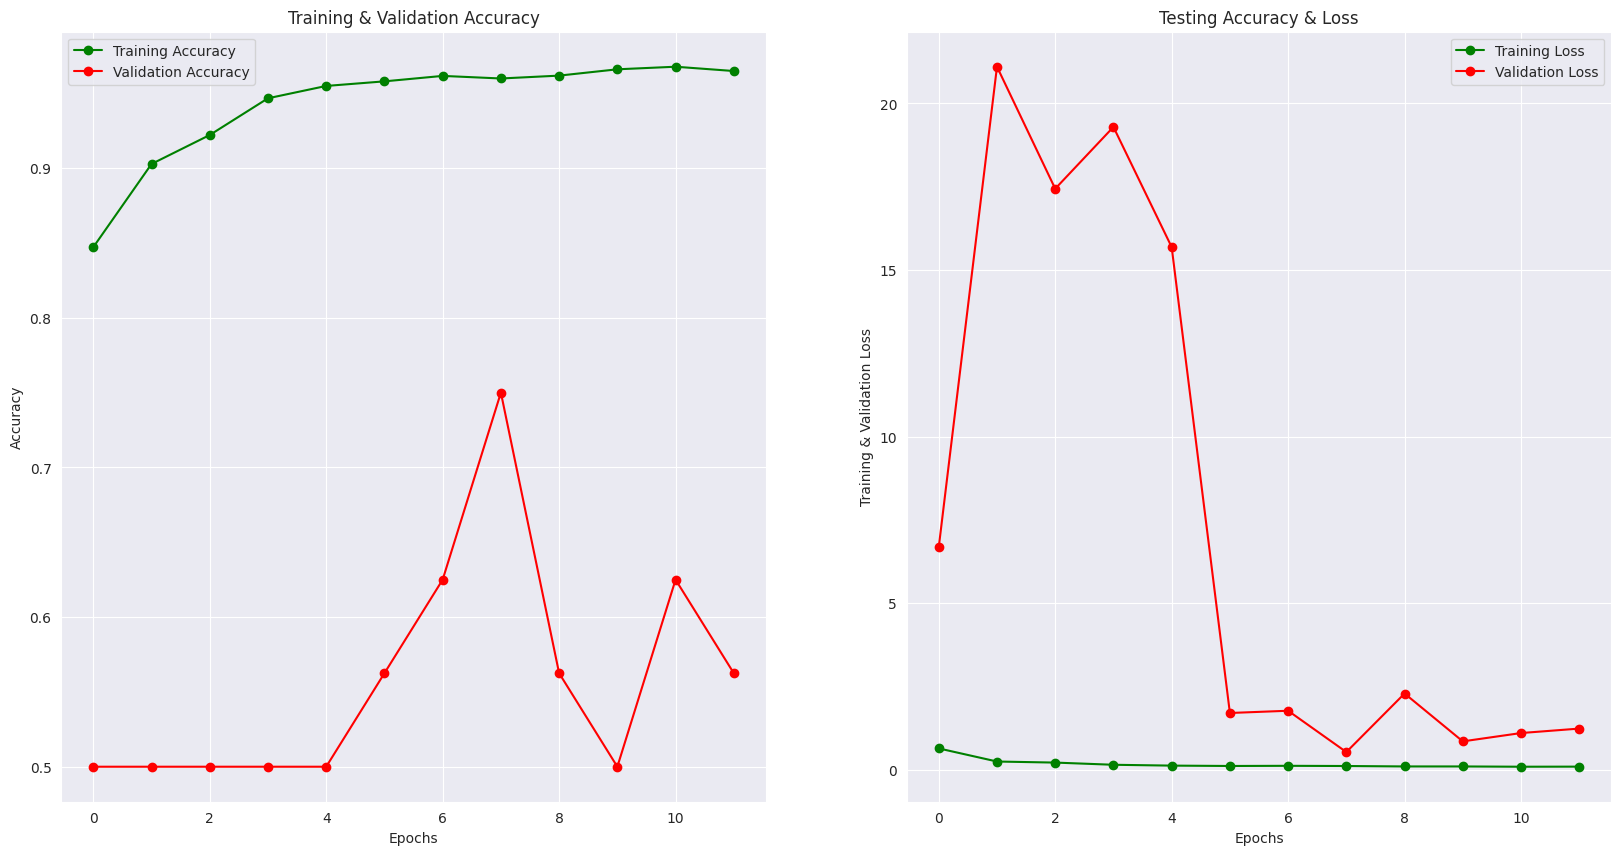

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
# predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 [==============================] - 1s 36ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0], dtype=int32)

In [23]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.92      0.86      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

In [25]:
cm = confusion_matrix(y_test,predictions)
cm

array([[373,  17],
       [ 32, 202]])

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

In [26]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Figure size 1000x1000 with 0 Axes>

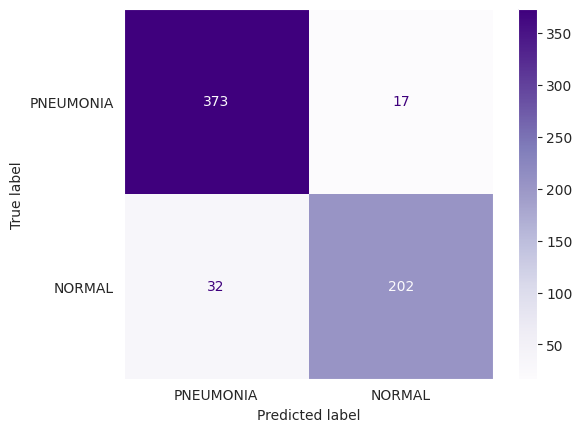

In [27]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [28]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

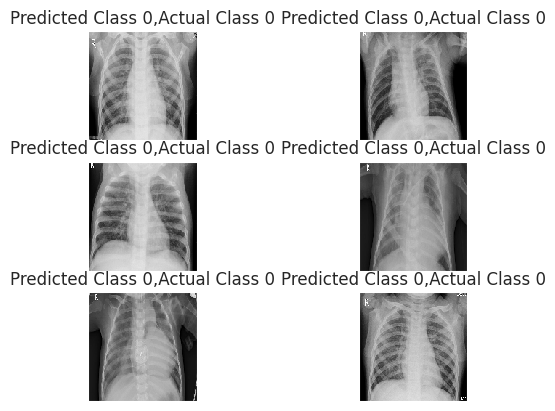

In [29]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

### Some incorrectly predicted classes

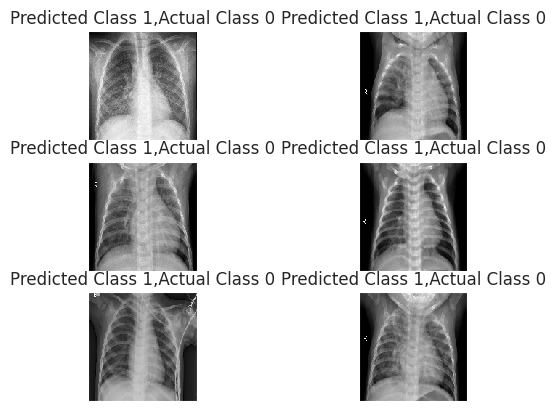

In [30]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

##Going to Part 2 of the assignment trying to Hyper-Parameter Optimization / Bayesian Optimization


In [31]:
!pip install optuna

In [32]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy

In [33]:
# def objective(trial):
#     # --- Hyperparameter suggestions ---
#     filters1 = trial.suggest_categorical('filters1', [32, 64])
#     dropout1 = trial.suggest_categorical('dropout1', [0.1, 0.15])
#     dropout2 = trial.suggest_categorical('dropout2', [0.15, 0.25])
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
#     learning_factor = trial.suggest_categorical('learning_factor', [0.1, 0.25, 0.5, 0.75, 0.9])

#     if filters1 == 32:
#         dense_units = trial.suggest_int('dense_units', 64, 128)
#     else:
#         dense_units = trial.suggest_int('dense_units', 128, 256)

#     # --- Build the model ---
#     model = Sequential()
#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1,activation='relu', padding='same', input_shape=(150, 150, 1)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 4, (kernel_size, kernel_size), strides =1, activation='relu', padding='same'))
#     model.add(Dropout(dropout2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout2))
#     model.add(Dense(1, activation='sigmoid'))

#     # --- Compile ---
#     model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

#     # --- Callbacks ---
#     callbacks = [
#         EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=learning_factor, min_lr=1e-6)
#     ]

#     # --- Train ---
#     history = model.fit(
#         datagen.flow(x_train, y_train, batch_size=32),
#         epochs=12,
#         validation_data=datagen.flow(x_val, y_val),
#         callbacks=callbacks
#     )

#     # Return validation accuracy of last epoch
#     return history.history['val_accuracy'][-1]


In [34]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

In [35]:
model10 = Sequential()
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(128 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Flatten())
model10.add(Dense(units = 70 , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(Dense(units = 1 , activation = 'sigmoid'))
model10.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model10.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 batch_normalization_5 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        25632     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 75, 75, 32)       

In [36]:
learning_rate_reduction10 = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model10.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=40, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction10])

Epoch 1/40
163/163 [==============================] - 29s 171ms/step - loss: 0.4115 - accuracy: 0.8338 - val_loss: 26.2392 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 26s 158ms/step - loss: 0.2534 - accuracy: 0.8992 - val_loss: 23.2464 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9256
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 26s 160ms/step - loss: 0.2010 - accuracy: 0.9256 - val_loss: 22.9474 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 26s 159ms/step - loss: 0.1481 - accuracy: 0.9431 - val_loss: 12.3116 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/40
163/163 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9532
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==================

In [ ]:
print("Loss of the model is - " , model10.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model10.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
predictions = (model10.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)

In [ ]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


##Part 3: XAI


In [ ]:
!pip uninstall -y tensorflow tensorflow-text tf-keras jax ml-dtypes protobuf grpcio-status google-cloud-pubsub


In [ ]:
!pip install tensorflow==2.18.0
!pip install tensorflow-text==2.18.1
!pip install tf-keras==2.18.0
!pip install jax==0.5.2
!pip install ml-dtypes==0.4.0
!pip install protobuf==5.26.1
!pip install grpcio-status==1.71.0
!pip install google-cloud-pubsub==2.29.0


In [ ]:
!pip install xplique==0.3.0


In [ ]:
!pip install xplique --upgrade

In [ ]:
import xplique
from xplique.plots import plot_attributions


In [ ]:
!pip install overcomplete


In [ ]:
import overcomplete

In [ ]:
from xplique.attributions import GradCAM
import tensorflow.keras.applications as app

In [ ]:
# Out pictures
# train, test, val, y_train, x_train, x_val, y_val, x_test, y_test


# X data is already preprocessed above
X = np.concatenate((x_train, x_val, x_test), axis = 0)
Y = np.concatenate((y_train, y_val, y_test), axis = 0)

#Create an explainer and generate explanations
explainer = GradCAM(model10)
explanations = explainer(X, Y)

